In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from utils import *
from data.categories import cat_map
%matplotlib inline

In [3]:
# Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [4]:
df = data_to_df(cat_map, min_year=2010)

In [5]:
df, class_array = preprocess_data(df, save_pqt=True)

In [6]:
df.head()

,text,categories,category_encoding
0,Coincidence of the oscillations in the dipole ...,[cond-mat.mes-hall],"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
1,Biased random walks on combs. We develop rigor...,[cond-mat.other],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
2,Superconducting states of the quasi-2D Holstei...,[cond-mat.supr-con],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Possibility of Gapless Spin Liquid State by On...,[cond-mat.str-el],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
4,A High Robustness and Low Cost Model for Casca...,[physics.soc-ph],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [8]:
class_array

array(['astro-ph', 'astro-ph.CO', 'astro-ph.EP', 'astro-ph.GA',
       'astro-ph.HE', 'astro-ph.IM', 'astro-ph.SR', 'cond-mat.dis-nn',
       'cond-mat.mes-hall', 'cond-mat.mtrl-sci', 'cond-mat.other',
       'cond-mat.quant-gas', 'cond-mat.soft', 'cond-mat.stat-mech',
       'cond-mat.str-el', 'cond-mat.supr-con', 'cs.AI', 'cs.CL', 'cs.CR',
       'cs.CV', 'cs.CY', 'cs.DB', 'cs.DC', 'cs.LO', 'cs.NI', 'cs.RO',
       'cs.SE', 'eess.SP', 'gr-qc', 'hep-ex', 'hep-lat', 'hep-ph',
       'hep-th', 'math.AG', 'math.AP', 'math.CA', 'math.CO', 'math.DG',
       'math.DS', 'math.FA', 'math.GT', 'math.NA', 'math.NT', 'math.OC',
       'math.PR', 'nlin.CD', 'nlin.PS', 'nucl-ex', 'nucl-th',
       'physics.acc-ph', 'physics.app-ph', 'physics.atom-ph',
       'physics.chem-ph', 'physics.class-ph', 'physics.flu-dyn',
       'physics.gen-ph', 'physics.ins-det', 'physics.optics',
       'physics.plasm-ph', 'physics.soc-ph', 'q-bio.PE', 'quant-ph',
       'stat.ME'], dtype=object)

In [33]:
from simpletransformers.classification import MultiLabelClassificationModel

model_args = {
    "reprocess_input_data": True,
    "overwrite_output_dir": True,
    "save_model_every_epoch": False, 
    "save_eval_checkpoints": False,
    "max_seq_length": 512,
    "train_batch_size": 16,
    "num_train_epochs": 4,
    "use_cuda":True
}

# Create a MultiLabelClassificationModel
model = MultiLabelClassificationModel('roberta', #distilbert
                                      'roberta-base',
                                      num_labels=len(class_array), 
                                      args=model_args)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForMultiLabelSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForMultiLabelSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'clas

In [34]:
from sklearn.model_selection import train_test_split

train_df, eval_df = train_test_split(df, test_size=0.1, stratify=df["categories"], random_state=42)

# Train the model
model.train_model(train_df[["text", "category_encoding"]])

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df[["text", "category_encoding"]])
print(result)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:377: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:896: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."



{'LRAP': 0.897336402302954, 'eval_loss': 0.01530684036195218}


In [120]:
sns.set_style('darkgrid')

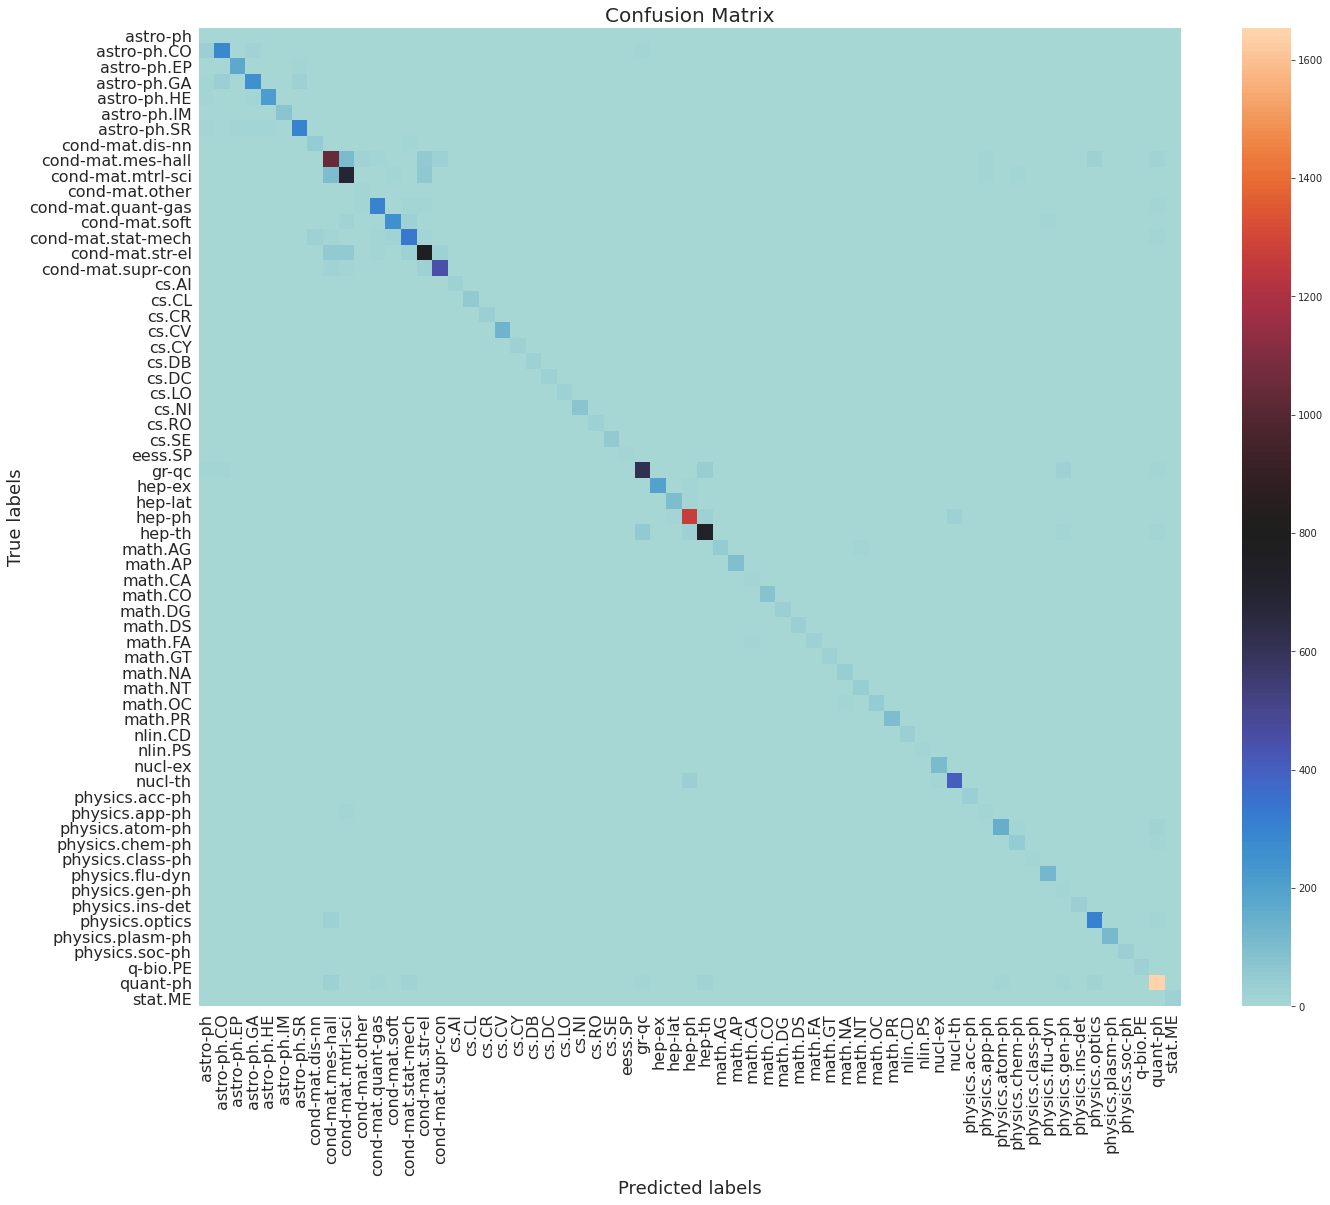

In [139]:
predicted_categories_argmax = list(map(lambda x: np.argmax(x), model_outputs))

predicted_categories_encoded = np.eye(len(class_array))[predicted_categories_argmax]
predicted_categories = class_array[np.nonzero(predicted_categories_encoded)[1]].tolist()

eval_gt_labels = eval_df["categories"].tolist()

plt.figure(figsize=(22,18))
cf_matrix = confusion_matrix(predicted_categories, eval_gt_labels, list(class_array))
ax = sns.heatmap(cf_matrix, center=800)
ax.set_xlabel('Predicted labels', fontsize=18)
ax.set_ylabel('True labels', fontsize=18)
ax.set_title('Confusion Matrix', fontsize=20)
ax.set_xticklabels(class_array, rotation=90, fontsize=16)
ax.set_yticklabels(class_array, rotation=0, fontsize=16)

plt.show()

In [81]:
import random

for _ in range(10):

    random_idx = random.randint(0, len(eval_df)-1)
    text = eval_df.iloc[random_idx]['text']
    true_categories = eval_df.iloc[random_idx]['categories']

    # Predict with trained multilabel classification model
    predicted_categories_encoded, raw_outputs = model.predict([text])
    predicted_categories_encoded = np.array(predicted_categories_encoded)
    predicted_categories_encoded[0][np.argmax(raw_outputs[0])] = 1
    predicted_categories = class_array[np.nonzero(predicted_categories_encoded[0])]

    print(f'True Categories:'.ljust(21,' '), f'{true_categories} - {cat_map[true_categories[0]]}\n')
    print(f'Predicted Categories: {predicted_categories} - {cat_map[predicted_categories[0]]}\n')
    print(f'Abstract: {text}\n\n')


True Categories:      ['hep-ex'] - High Energy Physics - Experiment

Predicted Categories: ['hep-ex'] - High Energy Physics - Experiment

Abstract: Search for leptoquarks coupled to third-generation quarks in
  proton-proton collisions at $\sqrt{s} =$ 13 TeV. Three of the most significant measured deviations from standard modelpredictions, the enhanced decay rate for B $\to$ D$^{(*)}\tau\nu$, hints oflepton universality violation in B $\to$ K$^{(*)}\ell\ell$ decays, and theanomalous magnetic moment of the muon, can be explained by the existence ofleptoquarks (LQs) with large couplings to third-generation quarks and masses atthe TeV scale. The existence of these states can be probed at the LHC in highenergy proton-proton collisions. A novel search is presented for pairproduction of LQs coupled to a top quark and a muon using data at acenter-of-mass energy of 13 TeV, corresponding to an integrated luminosity of35.9 fb$^{-1}$, recorded by the CMS experiment. No deviation from the standar


True Categories:      ['physics.optics'] - Optics

Predicted Categories: ['physics.optics'] - Optics

Abstract: Non-reciprocal geometric phase in nonlinear frequency conversion. We describe analytically and numerically the geometric phase arising fromnonlinear frequency conversion and show that such a phase can be madenon-reciprocal by momentum-dependent photonic transition. Such non-reciprocityis immune to the shortcomings imposed by dynamic reciprocity in Kerr andKerr-like devices. We propose a simple and practical implementation, requiringonly a single waveguide and one pump, while the geometric phase is controllableby the pump and promises robustness against fabrication errors.





True Categories:      ['quant-ph'] - Quantum Physics

Predicted Categories: ['quant-ph'] - Quantum Physics

Abstract: Perfect quantum transport in arbitrary spin networks. Spin chains have been proposed as wires to transport information betweendistributed registers in a quantum information processor. Unfortunately, thechallenges in manufacturing linear chains with engineered couplings hashindered experimental implementations. Here we present strategies to achieveperfect quantum information transport in arbitrary spin networks. Our proposalis based on the weak coupling limit for pure state transport, where informationis transferred between two end-spins that are only weakly coupled to the restof the network. This regime allows disregarding the complex, internal dynamicsof the bulk network and relying on virtual transitions or on the coupling to asingle bulk eigenmode. We further introduce control methods capable of tuningthe transport process and achieve perfect fidelity with limited r


True Categories:      ['cond-mat.mes-hall'] - Mesoscale and Nanoscale Physics

Predicted Categories: ['cond-mat.mes-hall'] - Mesoscale and Nanoscale Physics

Abstract: Possibility for exciton Bose-Einstein condensation in carbon nanotubes. We demonstrate a possibility for exciton Bose-Einstein condensation inindividual small-diameter (~1-2 nm) semiconducting carbon nanotubes. The effectoccurs under the exciton-interband-plasmon coupling controlled by an externalelectrostatic field applied perpendicular to the nanotube axis. It requiresfields ~1 V/nm and temperatures below 100 K that are experimentally accessible.The effect offers a testing ground for fundamentals of condensed matter physicsin one dimension and opens up perspectives to develop tunable coherentpolarized light source with carbon nanotubes.





True Categories:      ['nucl-th'] - Nuclear Theory

Predicted Categories: ['nucl-th'] - Nuclear Theory

Abstract: Sloppy nuclear energy density functionals: effective model reduction. Concepts from information geometry are used to analyse parameter sensitivityfor a nuclear energy density functional, representative of a class ofsemi-empirical functionals that start from a microscopically motivated ansatzfor the density dependence of the energy of a system of protons and neutrons.It is shown that such functionals are sloppy, characterized by an exponentialrange of sensitivity to parameter variations. Responsive to only a few stiffparameter combinations, they exhibit an exponential decrease of sensitivity tovariations of the remaining soft parameters. By interpreting the space of modelpredictions as a manifold embedded in the data space, with the parameters ofthe functional as coordinates on the manifold, it is also shown that theexponential distribution of model manifold widths correspo


True Categories:      ['astro-ph.CO'] - Cosmology and Nongalactic Astrophysics

Predicted Categories: ['astro-ph.CO'] - Cosmology and Nongalactic Astrophysics

Abstract: Turbulence decay in the density-stratified intracluster medium. Turbulence evolution in a density-stratified medium differs from that ofhomogeneous isotropic turbulence described by the Kolmogorov picture. Weevaluate the degree of this effect in the intracluster medium (ICM) withhydrodynamical simulations. We find that the buoyancy effect induced by ICMdensity stratification introduces qualitative changes to the turbulence energyevolution, morphology, and the density fluctuation - turbulence Mach numberrelation, and likely explains the radial dependence of the ICM turbulenceamplitude as found previously in cosmological simulations. A new channel ofenergy flow between the kinetic and the potential energy is opened up bybuoyancy. When the gravitational potential is kept constant with time, thisenergy flow leaves oscilla


True Categories:      ['cond-mat.supr-con'] - Superconductivity

Predicted Categories: ['cond-mat.supr-con'] - Superconductivity

Abstract: High pressure effects on the intermetallic superconductor
  Ti$_{0.85}$Pd$_{0.15}$. This work reports superconductivity studies in the intermetallicTi$_{0.85}$Pd$_{0.15}$ performed in normal conditions and under hydrostaticpressure. The crystal structure of the compound has a body centered cubic atroom temperature and atmospheric pressure as unstable $\beta$-Ti phase. X-Raydiffraction pattern shows space group $Im\bar{3}m$ with parameter $a=3.2226(4)$\AA and density around 5.6242 g/cm$^{3}$. The superconducting transitiontemperature, T$_{C}=3.7$ K was determined from resistance, magnetization, andspecific heat measurements. The two critical magnetic fields, the coherencelength, Ginzburg-Landau parameter, London penetration depth, thesuperconducting energy gap, the Debye temperature, the electron-phonon couplingconstant and density of states at the


True Categories:      ['hep-ex'] - High Energy Physics - Experiment

Predicted Categories: ['hep-ex'] - High Energy Physics - Experiment

Abstract: Search for New Dielectron Resonances and Randall-Sundrum Gravitons at
  the Collider Detector at Fermilab. A search for new dielectron mass resonances using data recorded by the CDF IIdetector and corresponding to an integrated luminosity of 5.7/fb is presented.No significant excess over the expected standard model prediction is observed.In this dataset, an event with the highest dielectron mass ever observed (960GeV/c^2) was recorded. The results are interpreted in the Randall-Sundrum (RS)model. Combined with the 5.4/fb diphoton analysis, the RS-graviton lower masslimit for the coupling k/\bar{M}_{Pl}=0.1 is 1058 GeV/c^2, making it thestrongest limit to date.





True Categories:      ['hep-ph'] - High Energy Physics - Phenomenology

Predicted Categories: ['hep-ph'] - High Energy Physics - Phenomenology

Abstract: Redefining the Axion Window. A major goal of axion searches is to reach inside the parameter space regionof realistic axion models. Currently, the boundaries of this region depend onsomewhat arbitrary criteria, and it would be desirable to specify them in termsof precise phenomenological requirements. We consider hadronic axion models andclassify the representations $R_Q$ of the new heavy quarks $Q$. By requiringthat $i)$ the $Q$ are sufficiently short lived to avoid issues with long livedstrongly interacting relics, $ii)$ no Landau poles are induced below the Planckscale, fifteen cases are selected, which define a phenomenologically preferredaxion window bounded by a maximum (minimum) value of the axion-photon couplingabout twice (four times) larger than commonly assumed. Allowing for more thanone $R_Q$, larger couplings, as well as


True Categories:      ['cond-mat.mes-hall'] - Mesoscale and Nanoscale Physics

Predicted Categories: ['cond-mat.mes-hall'] - Mesoscale and Nanoscale Physics

Abstract: Angular Dependent Magnetization Dynamics of Kagome Artificial Spin Ice
  Incorporating Topological Defects. We report angular-dependent spin-wave spectroscopy on kagome artificial spinice made of large arrays of interconnected Ni80Fe20 nanobars. Spectra taken insaturated and disordered states exhibit a series of resonances withcharacteristic in-plane angular dependencies. Micromagnetic simulations allowus to interpret characteristic resonances of a two-step magnetization reversalof the nanomagnets. The dynamic properties are consistent with topologicaldefects that are provoked via a magnetic field applied at specific angles.Simulations that we performed on previously investigated kagome artificial spinice consisting of isolated nanobars show characteristic discrepancies in thespin wave modes which we explain by the abse